In [105]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import stopwords 
from tqdm import tqdm
from collections import *
import operator

yelp_comments = pd.read_csv('reviews.csv')
yelp_comments.head()

yelp_comments.head()

yelp = yelp_comments[['business_id', 'review_date','review_text', 'business_id']]


In [107]:
yelp.head()

export_csv = yelp.to_csv(r'/home/matteob/Desktop/yelp.csv', index=None, header=True)

In [110]:
import os
import re
import math
import string
import requests
import json
from itertools import product
from inspect import getsourcefile
from io import open

# ##Constants##

# (empirically derived mean sentiment intensity rating increase for booster words)
B_INCR = 0.293
B_DECR = -0.293

# (empirically derived mean sentiment intensity rating increase for using ALLCAPs to emphasize a word)
C_INCR = 0.733
N_SCALAR = -0.74

# for removing punctuation
REGEX_REMOVE_PUNCTUATION = re.compile('[%s]' % re.escape(string.punctuation))

PUNC_LIST = [".", "!", "?", ",", ";", ":", "-", "'", "\"",
             "!!", "!!!", "??", "???", "?!?", "!?!", "?!?!", "!?!?"]
NEGATE = \
    ["aint", "arent", "cannot", "cant", "couldnt", "darent", "didnt", "doesnt",
     "ain't", "aren't", "can't", "couldn't", "daren't", "didn't", "doesn't",
     "dont", "hadnt", "hasnt", "havent", "isnt", "mightnt", "mustnt", "neither",
     "don't", "hadn't", "hasn't", "haven't", "isn't", "mightn't", "mustn't",
     "neednt", "needn't", "never", "none", "nope", "nor", "not", "nothing", "nowhere",
     "oughtnt", "shant", "shouldnt", "uhuh", "wasnt", "werent",
     "oughtn't", "shan't", "shouldn't", "uh-uh", "wasn't", "weren't",
     "without", "wont", "wouldnt", "won't", "wouldn't", "rarely", "seldom", "despite"]

# booster/dampener 'intensifiers' or 'degree adverbs'
# http://en.wiktionary.org/wiki/Category:English_degree_adverbs

BOOSTER_DICT = \
    {"absolutely": B_INCR, "amazingly": B_INCR, "awfully": B_INCR, "completely": B_INCR, "considerably": B_INCR,
     "decidedly": B_INCR, "deeply": B_INCR, "effing": B_INCR, "enormously": B_INCR,
     "entirely": B_INCR, "especially": B_INCR, "exceptionally": B_INCR, "extremely": B_INCR,
     "fabulously": B_INCR, "flipping": B_INCR, "flippin": B_INCR,
     "fricking": B_INCR, "frickin": B_INCR, "frigging": B_INCR, "friggin": B_INCR, "fully": B_INCR, "fucking": B_INCR,
     "greatly": B_INCR, "hella": B_INCR, "highly": B_INCR, "hugely": B_INCR, "incredibly": B_INCR,
     "intensely": B_INCR, "majorly": B_INCR, "more": B_INCR, "most": B_INCR, "particularly": B_INCR,
     "purely": B_INCR, "quite": B_INCR, "really": B_INCR, "remarkably": B_INCR,
     "so": B_INCR, "substantially": B_INCR,
     "thoroughly": B_INCR, "totally": B_INCR, "tremendously": B_INCR,
     "uber": B_INCR, "unbelievably": B_INCR, "unusually": B_INCR, "utterly": B_INCR,
     "very": B_INCR,
     "almost": B_DECR, "barely": B_DECR, "hardly": B_DECR, "just enough": B_DECR,
     "kind of": B_DECR, "kinda": B_DECR, "kindof": B_DECR, "kind-of": B_DECR,
     "less": B_DECR, "little": B_DECR, "marginally": B_DECR, "occasionally": B_DECR, "partly": B_DECR,
     "scarcely": B_DECR, "slightly": B_DECR, "somewhat": B_DECR,
     "sort of": B_DECR, "sorta": B_DECR, "sortof": B_DECR, "sort-of": B_DECR}

# check for sentiment laden idioms that do not contain lexicon words (future work, not yet implemented)
SENTIMENT_LADEN_IDIOMS = {"cut the mustard": 2, "hand to mouth": -2,
                          "back handed": -2, "blow smoke": -2, "blowing smoke": -2,
                          "upper hand": 1, "break a leg": 2,
                          "cooking with gas": 2, "in the black": 2, "in the red": -2,
                          "on the ball": 2, "under the weather": -2}

# check for special case idioms containing lexicon words
SPECIAL_CASE_IDIOMS = {"the shit": 3, "the bomb": 3, "bad ass": 1.5, "yeah right": -2,
                       "kiss of death": -1.5}


# #Static methods# #

def negated(input_words, include_nt=True):
    """
    Determine if input contains negation words
    """
    input_words = [str(w).lower() for w in input_words]
    neg_words = []
    neg_words.extend(NEGATE)
    for word in neg_words:
        if word in input_words:
            return True
    if include_nt:
        for word in input_words:
            if "n't" in word:
                return True
    if "least" in input_words:
        i = input_words.index("least")
        if i > 0 and input_words[i - 1] != "at":
            return True
    return False


def normalize(score, alpha=15):
    """
    Normalize the score to be between -1 and 1 using an alpha that
    approximates the max expected value
    """
    norm_score = score / math.sqrt((score * score) + alpha)
    if norm_score < -1.0:
        return -1.0
    elif norm_score > 1.0:
        return 1.0
    else:
        return norm_score


def allcap_differential(words):
    """
    Check whether just some words in the input are ALL CAPS
    :param list words: The words to inspect
    :returns: `True` if some but not all items in `words` are ALL CAPS
    """
    is_different = False
    allcap_words = 0
    for word in words:
        if word.isupper():
            allcap_words += 1
    cap_differential = len(words) - allcap_words
    if 0 < cap_differential < len(words):
        is_different = True
    return is_different


def scalar_inc_dec(word, valence, is_cap_diff):
    """
    Check if the preceding words increase, decrease, or negate/nullify the
    valence
    """
    scalar = 0.0
    word_lower = word.lower()
    if word_lower in BOOSTER_DICT:
        scalar = BOOSTER_DICT[word_lower]
        if valence < 0:
            scalar *= -1
        # check if booster/dampener word is in ALLCAPS (while others aren't)
        if word.isupper() and is_cap_diff:
            if valence > 0:
                scalar += C_INCR
            else:
                scalar -= C_INCR
    return scalar


class SentiText(object):
    """
    Identify sentiment-relevant string-level properties of input text.
    """

    def __init__(self, text):
        if not isinstance(text, str):
            text = str(text).encode('utf-8')
        self.text = text
        self.words_and_emoticons = self._words_and_emoticons()
        # doesn't separate words from\
        # adjacent punctuation (keeps emoticons & contractions)
        self.is_cap_diff = allcap_differential(self.words_and_emoticons)

    def _words_plus_punc(self):
        """
        Returns mapping of form:
        {
            'cat,': 'cat',
            ',cat': 'cat',
        }
        """
        no_punc_text = REGEX_REMOVE_PUNCTUATION.sub('', self.text)
        # removes punctuation (but loses emoticons & contractions)
        words_only = no_punc_text.split()
        # remove singletons
        words_only = set(w for w in words_only if len(w) > 1)
        # the product gives ('cat', ',') and (',', 'cat')
        punc_before = {''.join(p): p[1] for p in product(PUNC_LIST, words_only)}
        punc_after = {''.join(p): p[0] for p in product(words_only, PUNC_LIST)}
        words_punc_dict = punc_before
        words_punc_dict.update(punc_after)
        return words_punc_dict

    def _words_and_emoticons(self):
        """
        Removes leading and trailing puncutation
        Leaves contractions and most emoticons
            Does not preserve punc-plus-letter emoticons (e.g. :D)
        """
        wes = self.text.split()
        words_punc_dict = self._words_plus_punc()
        wes = [we for we in wes if len(we) > 1]
        for i, we in enumerate(wes):
            if we in words_punc_dict:
                wes[i] = words_punc_dict[we]
        return wes


class SentimentIntensityAnalyzer(object):
    """
    Give a sentiment intensity score to sentences.
    """

    def __init__(self, lexicon_file="vader_lexicon.txt", emoji_lexicon="emoji_utf8_lexicon.txt"):
        _this_module_file_path_ = os.path.abspath(getsourcefile(lambda: 0))
        lexicon_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), lexicon_file)
        with open(lexicon_full_filepath, encoding='utf-8') as f:
            self.lexicon_full_filepath = f.read()
        self.lexicon = self.make_lex_dict()

        emoji_full_filepath = os.path.join(os.path.dirname(_this_module_file_path_), emoji_lexicon)
        with open(emoji_full_filepath, encoding='utf-8') as f:
            self.emoji_full_filepath = f.read()
        self.emojis = self.make_emoji_dict()

    def make_lex_dict(self):
        """
        Convert lexicon file to a dictionary
        """
        lex_dict = {}
        for line in self.lexicon_full_filepath.split('\n'):
            (word, measure) = line.strip().split('\t')[0:2]
            lex_dict[word] = float(measure)
        return lex_dict

    def make_emoji_dict(self):
        """
        Convert emoji lexicon file to a dictionary
        """
        emoji_dict = {}
        for line in self.emoji_full_filepath.split('\n'):
            (emoji, description) = line.strip().split('\t')[0:2]
            emoji_dict[emoji] = description
        return emoji_dict

    def polarity_scores(self, text):
        """
        Return a float for sentiment strength based on the input text.
        Positive values are positive valence, negative value are negative
        valence.
        """
        # convert emojis to their textual descriptions
        text_token_list = text.split()
        text_no_emoji_lst = []
        for token in text_token_list:
            if token in self.emojis:
                # get the textual description
                description = self.emojis[token]
                text_no_emoji_lst.append(description)
            else:
                text_no_emoji_lst.append(token)
        text = " ".join(x for x in text_no_emoji_lst)

        sentitext = SentiText(text)

        sentiments = []
        words_and_emoticons = sentitext.words_and_emoticons
        for item in words_and_emoticons:
            valence = 0
            i = words_and_emoticons.index(item)
            # check for vader_lexicon words that may be used as modifiers or negations
            if item.lower() in BOOSTER_DICT:
                sentiments.append(valence)
                continue
            if (i < len(words_and_emoticons) - 1 and item.lower() == "kind" and
                    words_and_emoticons[i + 1].lower() == "of"):
                sentiments.append(valence)
                continue

            sentiments = self.sentiment_valence(valence, sentitext, item, i, sentiments)

        sentiments = self._but_check(words_and_emoticons, sentiments)

        valence_dict = self.score_valence(sentiments, text)

        return valence_dict

    def sentiment_valence(self, valence, sentitext, item, i, sentiments):
        is_cap_diff = sentitext.is_cap_diff
        words_and_emoticons = sentitext.words_and_emoticons
        item_lowercase = item.lower()
        if item_lowercase in self.lexicon:
            # get the sentiment valence
            valence = self.lexicon[item_lowercase]
            # check if sentiment laden word is in ALL CAPS (while others aren't)
            if item.isupper() and is_cap_diff:
                if valence > 0:
                    valence += C_INCR
                else:
                    valence -= C_INCR

            for start_i in range(0, 3):
                # dampen the scalar modifier of preceding words and emoticons
                # (excluding the ones that immediately preceed the item) based
                # on their distance from the current item.
                if i > start_i and words_and_emoticons[i - (start_i + 1)].lower() not in self.lexicon:
                    s = scalar_inc_dec(words_and_emoticons[i - (start_i + 1)], valence, is_cap_diff)
                    if start_i == 1 and s != 0:
                        s = s * 0.95
                    if start_i == 2 and s != 0:
                        s = s * 0.9
                    valence = valence + s
                    valence = self._negation_check(valence, words_and_emoticons, start_i, i)
                    if start_i == 2:
                        valence = self._special_idioms_check(valence, words_and_emoticons, i)

            valence = self._least_check(valence, words_and_emoticons, i)
        sentiments.append(valence)
        return sentiments

    def _least_check(self, valence, words_and_emoticons, i):
        # check for negation case using "least"
        if i > 1 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            if words_and_emoticons[i - 2].lower() != "at" and words_and_emoticons[i - 2].lower() != "very":
                valence = valence * N_SCALAR
        elif i > 0 and words_and_emoticons[i - 1].lower() not in self.lexicon \
                and words_and_emoticons[i - 1].lower() == "least":
            valence = valence * N_SCALAR
        return valence

    @staticmethod
    def _but_check(words_and_emoticons, sentiments):
        # check for modification in sentiment due to contrastive conjunction 'but'
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if 'but' in words_and_emoticons_lower:
            bi = words_and_emoticons_lower.index('but')
            for sentiment in sentiments:
                si = sentiments.index(sentiment)
                if si < bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 0.5)
                elif si > bi:
                    sentiments.pop(si)
                    sentiments.insert(si, sentiment * 1.5)
        return sentiments

    @staticmethod
    def _special_idioms_check(valence, words_and_emoticons, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        onezero = "{0} {1}".format(words_and_emoticons_lower[i - 1], words_and_emoticons_lower[i])

        twoonezero = "{0} {1} {2}".format(words_and_emoticons_lower[i - 2],
                                          words_and_emoticons_lower[i - 1], words_and_emoticons_lower[i])

        twoone = "{0} {1}".format(words_and_emoticons_lower[i - 2], words_and_emoticons_lower[i - 1])

        threetwoone = "{0} {1} {2}".format(words_and_emoticons_lower[i - 3],
                                           words_and_emoticons_lower[i - 2], words_and_emoticons_lower[i - 1])

        threetwo = "{0} {1}".format(words_and_emoticons_lower[i - 3], words_and_emoticons_lower[i - 2])

        sequences = [onezero, twoonezero, twoone, threetwoone, threetwo]

        for seq in sequences:
            if seq in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[seq]
                break

        if len(words_and_emoticons_lower) - 1 > i:
            zeroone = "{0} {1}".format(words_and_emoticons_lower[i], words_and_emoticons_lower[i + 1])
            if zeroone in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroone]
        if len(words_and_emoticons_lower) - 1 > i + 1:
            zeroonetwo = "{0} {1} {2}".format(words_and_emoticons_lower[i], words_and_emoticons_lower[i + 1],
                                              words_and_emoticons_lower[i + 2])
            if zeroonetwo in SPECIAL_CASE_IDIOMS:
                valence = SPECIAL_CASE_IDIOMS[zeroonetwo]

        # check for booster/dampener bi-grams such as 'sort of' or 'kind of'
        n_grams = [threetwoone, threetwo, twoone]
        for n_gram in n_grams:
            if n_gram in BOOSTER_DICT:
                valence = valence + BOOSTER_DICT[n_gram]
        return valence

    @staticmethod
    def _sentiment_laden_idioms_check(valence, senti_text_lower):
        # Future Work
        # check for sentiment laden idioms that don't contain a lexicon word
        idioms_valences = []
        for idiom in SENTIMENT_LADEN_IDIOMS:
            if idiom in senti_text_lower:
                print(idiom, senti_text_lower)
                valence = SENTIMENT_LADEN_IDIOMS[idiom]
                idioms_valences.append(valence)
        if len(idioms_valences) > 0:
            valence = sum(idioms_valences) / float(len(idioms_valences))
        return valence

    @staticmethod
    def _negation_check(valence, words_and_emoticons, start_i, i):
        words_and_emoticons_lower = [str(w).lower() for w in words_and_emoticons]
        if start_i == 0:
            if negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 1 word preceding lexicon word (w/o stopwords)
                valence = valence * N_SCALAR
        if start_i == 1:
            if words_and_emoticons_lower[i - 2] == "never" and \
                    (words_and_emoticons_lower[i - 1] == "so" or
                     words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 2] == "without" and \
                    words_and_emoticons_lower[i - 1] == "doubt":
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 2 words preceding the lexicon word position
                valence = valence * N_SCALAR
        if start_i == 2:
            if words_and_emoticons_lower[i - 3] == "never" and \
                    (words_and_emoticons_lower[i - 2] == "so" or words_and_emoticons_lower[i - 2] == "this") or \
                    (words_and_emoticons_lower[i - 1] == "so" or words_and_emoticons_lower[i - 1] == "this"):
                valence = valence * 1.25
            elif words_and_emoticons_lower[i - 3] == "without" and \
                    (words_and_emoticons_lower[i - 2] == "doubt" or words_and_emoticons_lower[i - 1] == "doubt"):
                valence = valence
            elif negated([words_and_emoticons_lower[i - (start_i + 1)]]):  # 3 words preceding the lexicon word position
                valence = valence * N_SCALAR
        return valence

    def _punctuation_emphasis(self, text):
        # add emphasis from exclamation points and question marks
        ep_amplifier = self._amplify_ep(text)
        qm_amplifier = self._amplify_qm(text)
        punct_emph_amplifier = ep_amplifier + qm_amplifier
        return punct_emph_amplifier

    @staticmethod
    def _amplify_ep(text):
        # check for added emphasis resulting from exclamation points (up to 4 of them)
        ep_count = text.count("!")
        if ep_count > 4:
            ep_count = 4
        # (empirically derived mean sentiment intensity rating increase for
        # exclamation points)
        ep_amplifier = ep_count * 0.292
        return ep_amplifier

    @staticmethod
    def _amplify_qm(text):
        # check for added emphasis resulting from question marks (2 or 3+)
        qm_count = text.count("?")
        qm_amplifier = 0
        if qm_count > 1:
            if qm_count <= 3:
                # (empirically derived mean sentiment intensity rating increase for
                # question marks)
                qm_amplifier = qm_count * 0.18
            else:
                qm_amplifier = 0.96
        return qm_amplifier

    @staticmethod
    def _sift_sentiment_scores(sentiments):
        # want separate positive versus negative sentiment scores
        pos_sum = 0.0
        neg_sum = 0.0
        neu_count = 0
        for sentiment_score in sentiments:
            if sentiment_score > 0:
                pos_sum += (float(sentiment_score) + 1)  # compensates for neutral words that are counted as 1
            if sentiment_score < 0:
                neg_sum += (float(sentiment_score) - 1)  # when used with math.fabs(), compensates for neutrals
            if sentiment_score == 0:
                neu_count += 1
        return pos_sum, neg_sum, neu_count

    def score_valence(self, sentiments, text):
        if sentiments:
            sum_s = float(sum(sentiments))
            # compute and add emphasis from punctuation in text
            punct_emph_amplifier = self._punctuation_emphasis(text)
            if sum_s > 0:
                sum_s += punct_emph_amplifier
            elif sum_s < 0:
                sum_s -= punct_emph_amplifier

            compound = normalize(sum_s)
            # discriminate between positive, negative and neutral sentiment scores
            pos_sum, neg_sum, neu_count = self._sift_sentiment_scores(sentiments)

            if pos_sum > math.fabs(neg_sum):
                pos_sum += punct_emph_amplifier
            elif pos_sum < math.fabs(neg_sum):
                neg_sum -= punct_emph_amplifier

            total = pos_sum + math.fabs(neg_sum) + neu_count
            pos = math.fabs(pos_sum / total)
            neg = math.fabs(neg_sum / total)
            neu = math.fabs(neu_count / total)

        else:
            compound = 0.0
            pos = 0.0
            neg = 0.0
            neu = 0.0

        sentiment_dict = \
            {"neg": round(neg, 3),
             "neu": round(neu, 3),
             "pos": round(pos, 3),
             "compound": round(compound, 4)}

        return compound

In [ ]:
if __name__ == '__main__':
    
    analyzer = SentimentIntensityAnalyzer()
    
##Append review scores from specific years to its respective list
    score_08=[]
    score_09=[]
    score_10=[]
    score_11=[]
    score_12=[]
    score_13=[]
    score_14=[]
    score_15=[]
    score_16=[]
    score_17=[]
    score_18=[]
     
    for i in range(yelp_comments.shape[0]):
        if (isinstance(yelp_comments.iloc[i][13],str)):
            vs = analyzer.polarity_scores(yelp_comments.iloc[i][13])
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2008:
                 score_08.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2009:
                 score_09.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2010:
                score_10.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2011:
                score_11.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2012:
                score_12.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2013:
                score_13.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2014:
                score_14.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2015:
                score_15.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2016:
                score_16.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2017:
                score_17.append(vs)
            if int(yelp_comments.iloc[i][10].split("/")[2].split("\n")[0])==2018:
                score_18.append(vs)
       
    scores_years=[score_08, score_09, score_10, score_11, score_12, score_13, score_14, score_15, score_16, score_17, score_18]


In [112]:
stars=['*','**','***','****','*****']]
lf= pd.DataFrame(index=stars



scores_per_year={}
year=2008


for x in scores_years:
    dictionary=[]
    counter1 = 0
    counter2 = 0
    counter3 = 0
    counter4 = 0
    counter5 = 0
    for score in x:
        if (score <=-0.6):
            counter1+=1
        elif (score<=-0.2):
            counter2+=1
        elif (score <=0.2):
            counter3+=1
        elif (score<=0.6):
            counter4+=1
        elif (score <=1):
            counter5+=1
    dictionary.append((counter1/len(x))*100)
    dictionary.append((counter2/len(x))*100)
    dictionary.append((counter3/len(x))*100)
    dictionary.append((counter4/len(x))*100)
    dictionary.append((counter5/len(x))*100)
    lf[year]=dictionary
    year+=1

print(lf)

SyntaxError: invalid syntax (<ipython-input-112-b6a9ab2808e7>, line 1)

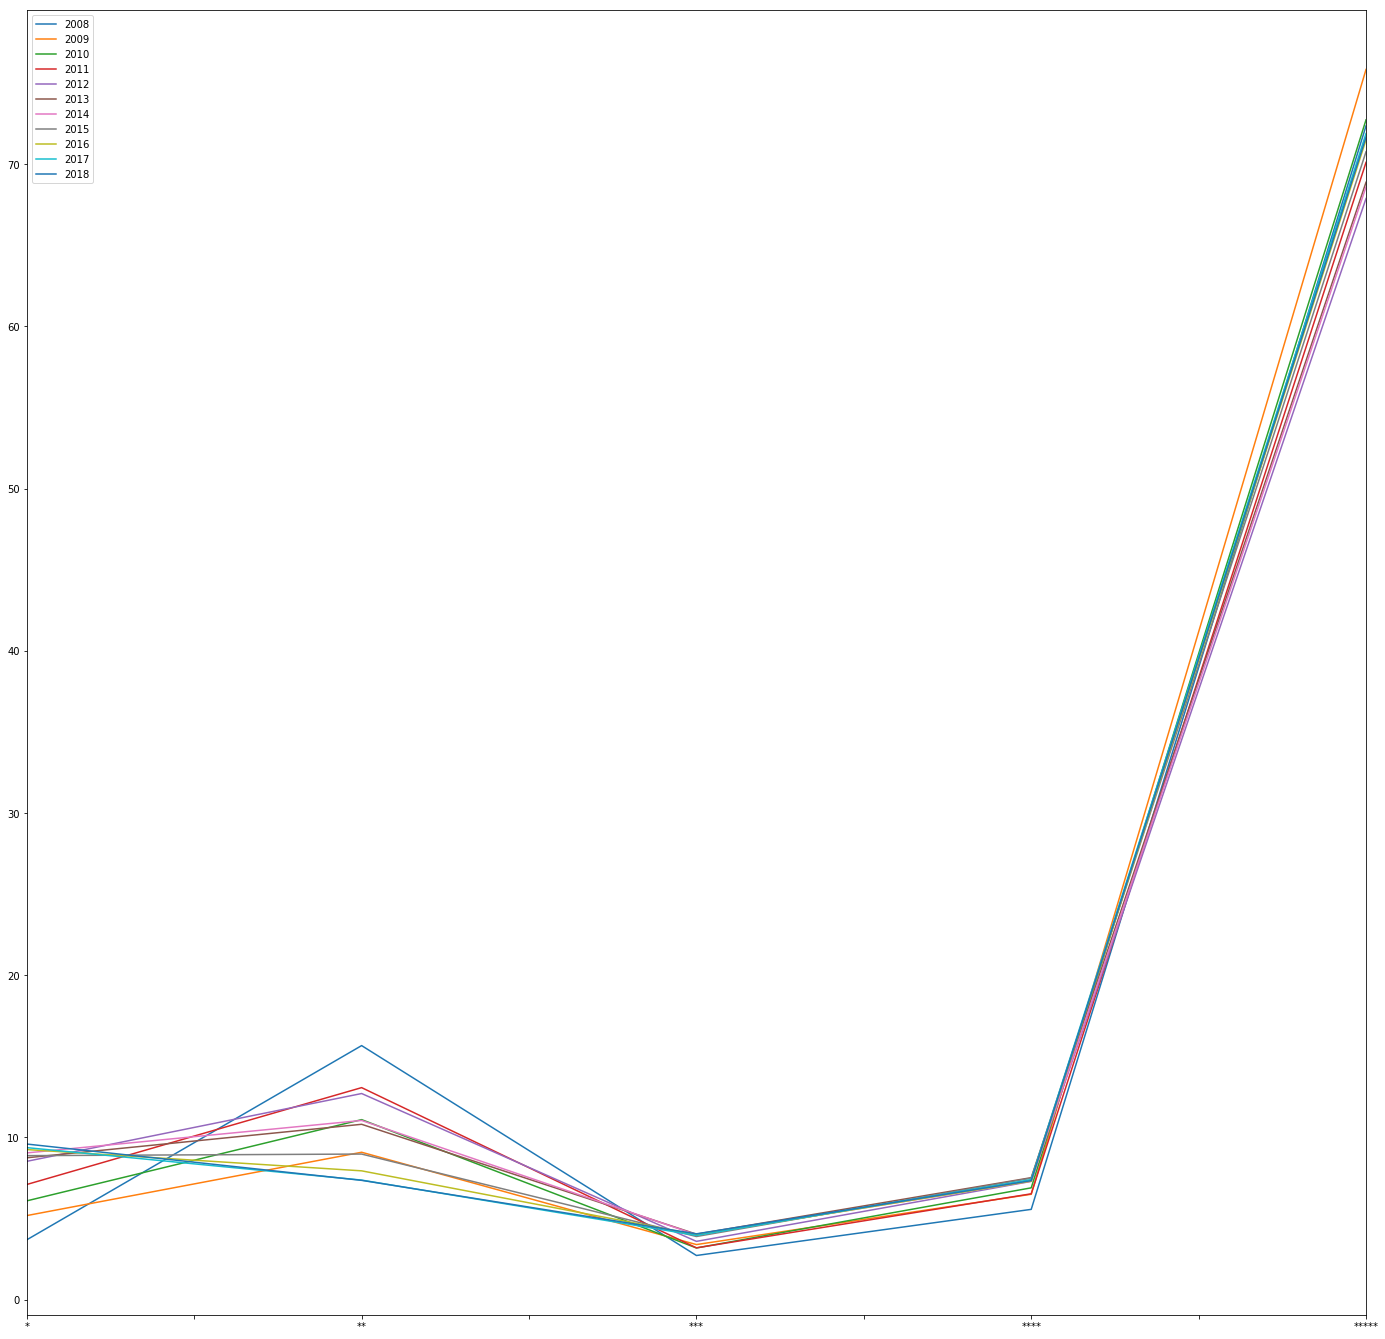

In [94]:
lf.plot(figsize=(24,24))

In [72]:
import matplotlib.pyplot as plt
plt.close('all')

             *         **       ***      ****      *****
2008  3.688653  15.661144  2.719600  5.564239  72.366364
2009  5.181221   9.085381  3.393335  6.494770  75.845293
2010  6.088965  11.096257  3.184249  6.891104  72.739426
2011  7.098828  13.069837  3.190408  6.523064  70.117862
2012  8.526513  12.706176  3.590767  7.288833  67.887711
2013  8.744611  10.809053  4.035974  7.518210  68.892151
2014  9.044745  11.045795  3.999475  7.306128  68.603858
2015  8.876221   8.973595  3.890260  7.487450  70.772474
2016  9.250961   7.939323  3.993226  7.309066  71.507425
2017  9.370404   7.369059  3.958347  7.403055  71.899135
2018  9.591130   7.352888  4.055600  7.334902  71.665480


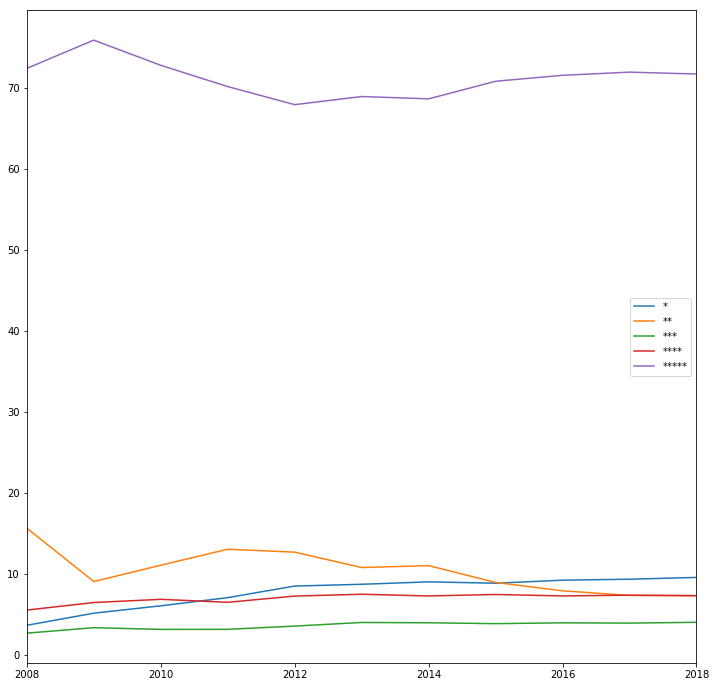

In [98]:
lf1=lf.T
print(lf1)
lf1.plot(figsize=(12,12))